### This aims to classify the exosome staus based on a featureset derrived from the peaks.

Import Libraries

In [36]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from scipy.integrate import simps
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

Read the spectral data

In [37]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

Remove the noise from the spectra using Savitzky–Golay-filtering

In [38]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 7
poly_order = 3

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = savgol_filter(df['Absorbance'], window_size, poly_order)

Then carry out baseline correction using Asymmetric Least Squares Smoothing to remove the background fluorescence from the spectra.

In [39]:
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

lam = 10**3  # Adjust the regularisation parameter
p = 0.01    # Adjust the asymmetry parameter
df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: baseline_als(x, lam=lam, p=p))

Remove the noise from the spectra using Savitzky–Golay-filtering

In [40]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 7
poly_order = 3

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = savgol_filter(df['Baseline_Corrected_Absorbance'], window_size, poly_order)

## 1 Sample Example

In [41]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber  Absorbance     SurID         Status  \
7981415  210526-3-04     0   200.00000   3094.2837  210526-3  Hyperglycemia   
7981416  210526-3-04     1   200.68336   3109.5640  210526-3  Hyperglycemia   
7981417  210526-3-04     2   201.36674   3041.8801  210526-3  Hyperglycemia   
7981418  210526-3-04     3   202.05011   3033.1189  210526-3  Hyperglycemia   
7981419  210526-3-04     4   202.73349   3061.7734  210526-3  Hyperglycemia   
...              ...   ...         ...         ...       ...            ...   
7984045  210526-3-04  2630  1997.26650   1646.8857  210526-3  Hyperglycemia   
7984046  210526-3-04  2631  1997.94980   1655.2378  210526-3  Hyperglycemia   
7984047  210526-3-04  2632  1998.63330   1652.1541  210526-3  Hyperglycemia   
7984048  210526-3-04  2633  1999.31670   1644.7822  210526-3  Hyperglycemia   
7984049  210526-3-04  2634  2000.00000   1638.7900  210526-3  Hyperglycemia   

         Smoothed_Absorbance  Baseline_Corrected_Ab

Find the peaks of each the differently smoothed spectra

In [45]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

raw_peaks, _ = find_peaks(x=sample['Absorbance'])
smooth_peaks, _ = find_peaks(x=sample['Smoothed_Absorbance'])
baseline_peaks, _ = find_peaks(x=sample['Baseline_Corrected_Absorbance'])

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

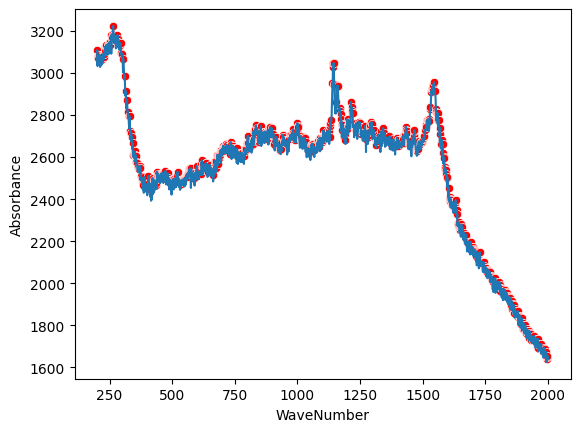

In [46]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[raw_peaks], x="WaveNumber", y="Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

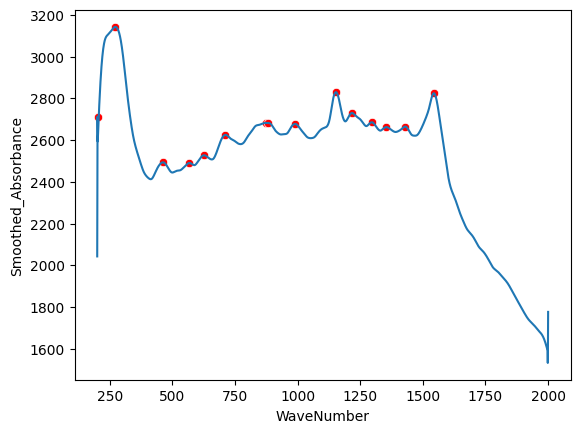

In [47]:
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[smooth_peaks], x="WaveNumber", y="Smoothed_Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

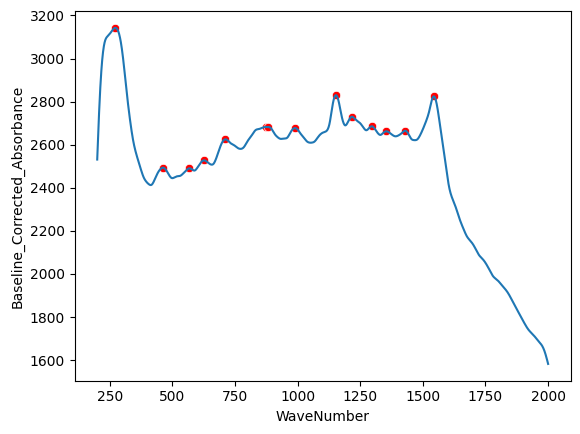

In [48]:
sns.lineplot(x="WaveNumber", y='Baseline_Corrected_Absorbance', data=sample)
sns.scatterplot(data=sample.iloc[baseline_peaks], x="WaveNumber", y="Baseline_Corrected_Absorbance", color="red")

The average baseline corrected spectrum of each status

<AxesSubplot: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

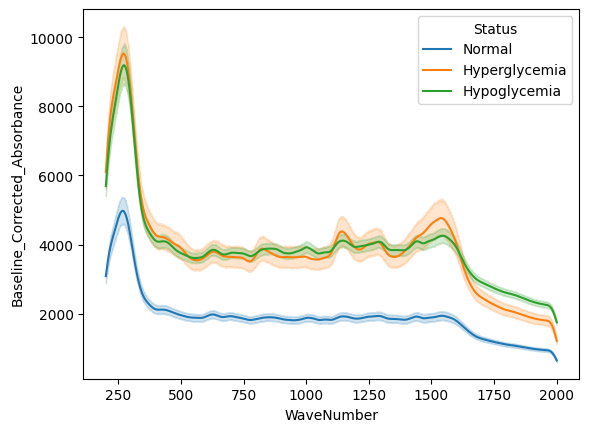

In [13]:
sns.lineplot(data=df, x='WaveNumber', y='Baseline_Corrected_Absorbance', hue='Status')

#### Machine Learning

In [14]:
spectra_df = df.drop(columns=['Absorbance', 'Smoothed_Absorbance'])

In [15]:
spectra_df = spectra_df.rename(columns={'Baseline_Corrected_Absorbance':'Absorbance'})

#### First we will look at the full wavelength.

Create a field for each wavelength.

In [16]:
wavelength_df = spectra_df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
wavelength_df.columns.name = None

Add the statuses back.

In [17]:
statuses = spectra_df[['SpecID', 'Status']].drop_duplicates()
wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')
wavelength_df = wavelength_df.set_index('SpecID')

In [18]:
wavelength_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,2654.033104,2650.502362,2646.972158,2643.443542,2639.918012,2636.397436,2632.883921,2629.379847,2625.887878,2622.410856,...,970.517892,964.663500,958.742791,952.769910,946.760414,940.731238,934.700736,928.688719,922.684698,Normal
201210-1-01,2417.749679,2433.853833,2449.893565,2465.808987,2481.547184,2497.060129,2512.304415,2527.241064,2541.835387,2556.056788,...,1126.853794,1120.284058,1113.637015,1106.929456,1100.179721,1093.407817,1086.635519,1079.886473,1073.147428,Normal
201210-1-02,2936.604711,2953.386410,2970.092853,2986.654525,3003.010664,3019.106601,3034.893606,3050.328445,3065.373005,3079.993850,...,1671.134856,1657.291108,1643.244102,1629.037429,1614.718871,1600.340586,1585.959260,1571.636194,1557.338351,Normal
201210-1-03,6532.873950,6631.606499,6729.938283,6827.481677,6923.871199,7018.758315,7111.811892,7202.718964,7291.185382,7376.936287,...,1603.904732,1597.867115,1591.769339,1585.624178,1579.445570,1573.248820,1567.050670,1560.869323,1554.695281,Normal
201210-1-04,2940.846120,2956.179842,2971.448530,2986.591423,3001.554439,3016.288265,3030.748116,3044.893480,3058.687951,3072.099095,...,1611.124567,1604.562943,1597.931910,1591.246623,1584.523674,1577.781174,1571.038827,1564.317988,1557.606415,Normal


##### 1. Training a Random Forest and Extra Trees Classifer on the whole spectrum.

In [19]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [26]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [27]:
# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status'], axis=1)
y = wavelength_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8466 +/- 0.0215
ExtraTreesClassifier Cross-Validation Accuracy: 0.8778 +/- 0.0212


#### 2. Using Peak Statistics

This uses statistical properties of the peaks in each sample to be used as additional features.

In [28]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    # peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

In [29]:
print(len(peaks))
print(len(widths))
print(len(prominences))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

44338
44338
44338


/tmp/ipykernel_5786/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_5786/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [30]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences
369,201210-1-00,369,452.16400,201210-1,Normal,1739.503084,8.160418,0.115529
473,201210-1-00,473,523.23462,201210-1,Normal,1692.191960,16.602085,1.083241
609,201210-1-00,609,616.17310,201210-1,Normal,1777.039133,57.705204,95.045107
726,201210-1-00,726,696.12756,201210-1,Normal,1758.408784,54.863932,93.454117
1002,201210-1-00,1002,884.73804,201210-1,Normal,1703.092522,110.297735,88.565242


Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [31]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [32]:
peak_stats = pd.merge(peak_stats, statuses, on='SpecID')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(False)

In [33]:
peak_stats.head()

,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min,Status
SpecID,,,,,,,,,,,,,,
201210-1-00,1566.015160,174.516486,15,1777.039133,1099.157334,41.133509,29.300976,110.297735,8.115483,26.819709,36.157943,95.045107,0.093330,Normal
201210-1-01,1828.490688,338.144022,13,2772.351740,1260.897759,61.145725,39.291037,141.537086,21.131442,66.983718,95.293746,354.602061,5.021627,Normal
201210-1-02,2259.235573,323.319918,16,3285.403913,1913.637910,64.416101,46.216686,181.885024,5.759413,127.981610,202.493746,761.716617,0.041292,Normal
201210-1-03,3207.042023,1705.045622,11,8296.751658,2288.184593,76.231878,75.346473,299.091082,17.566878,409.149814,531.781838,1763.877708,3.613375,Normal
201210-1-04,2297.882286,284.454808,14,3249.390970,2110.621043,111.640805,183.630652,735.265186,25.783141,77.380344,110.141614,345.617436,4.524757,Normal


In [34]:
# Splitting the dataframe into features (X) and target variable (y)
X = peak_stats.drop(['Status'], axis=1)
y = peak_stats['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8121 +/- 0.0176
ExtraTreesClassifier Cross-Validation Accuracy: 0.8250 +/- 0.0162


Combine these peak statistics with the full wavelength

In [35]:
stats_and_spectrum = peak_stats.merge(wavelength_df.drop(columns='Status'), on='SpecID')

In [36]:
stats_and_spectrum.head()

,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,...,1993.8496,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1566.015160,174.516486,15,1777.039133,1099.157334,41.133509,29.300976,110.297735,8.115483,26.819709,...,976.293099,970.517892,964.663500,958.742791,952.769910,946.760414,940.731238,934.700736,928.688719,922.684698
201210-1-01,1828.490688,338.144022,13,2772.351740,1260.897759,61.145725,39.291037,141.537086,21.131442,66.983718,...,1133.330858,1126.853794,1120.284058,1113.637015,1106.929456,1100.179721,1093.407817,1086.635519,1079.886473,1073.147428
201210-1-02,2259.235573,323.319918,16,3285.403913,1913.637910,64.416101,46.216686,181.885024,5.759413,127.981610,...,1684.735755,1671.134856,1657.291108,1643.244102,1629.037429,1614.718871,1600.340586,1585.959260,1571.636194,1557.338351
201210-1-03,3207.042023,1705.045622,11,8296.751658,2288.184593,76.231878,75.346473,299.091082,17.566878,409.149814,...,1609.870387,1603.904732,1597.867115,1591.769339,1585.624178,1579.445570,1573.248820,1567.050670,1560.869323,1554.695281
201210-1-04,2297.882286,284.454808,14,3249.390970,2110.621043,111.640805,183.630652,735.265186,25.783141,77.380344,...,1617.602891,1611.124567,1604.562943,1597.931910,1591.246623,1584.523674,1577.781174,1571.038827,1564.317988,1557.606415


In [37]:
# Splitting the dataframe into features (X) and target variable (y)
X = stats_and_spectrum.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = stats_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8532 +/- 0.0188
ExtraTreesClassifier Cross-Validation Accuracy: 0.8746 +/- 0.0175


#### 3. Creating a uniform Peak Featureset

This aims to create a featureset using peaks within wavenumber intervals.

First get the peak properties

In [20]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    #peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

In [21]:
print(len(peaks))
print(len(widths))
print(len(prominences))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

44338
44338
44338


/tmp/ipykernel_3818/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_3818/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [22]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences
369,201210-1-00,369,452.16400,201210-1,Normal,1739.503084,8.160418,0.115529
473,201210-1-00,473,523.23462,201210-1,Normal,1692.191960,16.602085,1.083241
609,201210-1-00,609,616.17310,201210-1,Normal,1777.039133,57.705204,95.045107
726,201210-1-00,726,696.12756,201210-1,Normal,1758.408784,54.863932,93.454117
1002,201210-1-00,1002,884.73804,201210-1,Normal,1703.092522,110.297735,88.565242


Assign Peaks to bins of a fixed wavelength interval.

In [23]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

/tmp/ipykernel_3818/464682704.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [24]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences,Bin
369,201210-1-00,369,452.16400,201210-1,Normal,1739.503084,8.160418,0.115529,450-475
473,201210-1-00,473,523.23462,201210-1,Normal,1692.191960,16.602085,1.083241,500-525
609,201210-1-00,609,616.17310,201210-1,Normal,1777.039133,57.705204,95.045107,600-625
726,201210-1-00,726,696.12756,201210-1,Normal,1758.408784,54.863932,93.454117,675-700
1002,201210-1-00,1002,884.73804,201210-1,Normal,1703.092522,110.297735,88.565242,875-900


Set the bins as columns with the peak absrobances, widths and prominences as the values.
If no peaks appear in a bin the value is set to False.
If multiple peaks appear their properties are aggregated.

In [25]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='max')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with False
peak_bins.fillna(False, inplace=True)

In [26]:
peak_bins.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,PeakWidths_775-800,PeakWidths_800-825,PeakWidths_825-850,PeakWidths_850-875,PeakWidths_875-900,PeakWidths_900-925,PeakWidths_925-950,PeakWidths_950-975,PeakWidths_975-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,False,False,1619.763905,False,False,1562.486406,False,False,False,1527.296427,...,False,False,False,False,110.297735,False,False,False,67.90432,Normal
201210-1-01,1825.675196,False,1769.781641,False,False,1726.26742,False,False,False,False,...,False,False,False,False,False,141.537086,False,False,False,Normal
201210-1-02,False,2200.054511,False,False,False,2150.877876,False,False,False,2138.247544,...,False,False,False,False,False,58.721453,False,False,115.64127,Normal
201210-1-03,False,False,2628.147678,False,False,False,2988.250203,False,False,False,...,False,False,False,False,False,299.091082,False,False,73.576413,Normal
201210-1-04,2173.513516,False,2156.021692,False,False,False,False,2221.602156,False,False,...,False,False,False,False,False,106.286132,False,False,False,Normal


In [27]:
# Splitting the dataframe into features (X) and target variable (y)
X = peak_bins.drop(['Status'], axis=1)
y = peak_bins['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8522 +/- 0.0220
ExtraTreesClassifier Cross-Validation Accuracy: 0.8677 +/- 0.0261


Merge with the full spectrum.

In [28]:
bins_and_spectrum = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')

/tmp/ipykernel_3818/2474809401.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bins_and_spectrum = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')


In [29]:
bins_and_spectrum.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,1993.8496,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,False,False,1619.763905,False,False,1562.486406,False,False,False,1527.296427,...,976.293099,970.517892,964.663500,958.742791,952.769910,946.760414,940.731238,934.700736,928.688719,922.684698
201210-1-01,1825.675196,False,1769.781641,False,False,1726.26742,False,False,False,False,...,1133.330858,1126.853794,1120.284058,1113.637015,1106.929456,1100.179721,1093.407817,1086.635519,1079.886473,1073.147428
201210-1-02,False,2200.054511,False,False,False,2150.877876,False,False,False,2138.247544,...,1684.735755,1671.134856,1657.291108,1643.244102,1629.037429,1614.718871,1600.340586,1585.959260,1571.636194,1557.338351
201210-1-03,False,False,2628.147678,False,False,False,2988.250203,False,False,False,...,1609.870387,1603.904732,1597.867115,1591.769339,1585.624178,1579.445570,1573.248820,1567.050670,1560.869323,1554.695281
201210-1-04,2173.513516,False,2156.021692,False,False,False,False,2221.602156,False,False,...,1617.602891,1611.124567,1604.562943,1597.931910,1591.246623,1584.523674,1577.781174,1571.038827,1564.317988,1557.606415


In [30]:
# Splitting the dataframe into features (X) and target variable (y)
X = bins_and_spectrum.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = bins_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8782 +/- 0.0191
ExtraTreesClassifier Cross-Validation Accuracy: 0.8969 +/- 0.0163


In [31]:
# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Training the classifier on the entire dataset
    clf.fit(X, y)
    
    # Displaying the cross-validation results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')
    
    # Displaying the top 10 most important features
    feature_importances = clf.feature_importances_
    indices = np.argsort(feature_importances)[::-1][:10]  # Get indices of top 10 features
    top_features = X.columns[indices]
    print(f'Top 10 Features: {top_features}')

RandomForestClassifier Cross-Validation Accuracy: 0.8782 +/- 0.0191
Top 10 Features: Index(['PeakWidths_250-275', '1997.9498', '1999.3167', '1997.2665',
       'PeakWidths_275-300', '1991.7996', '1996.5831', '1992.4829',
       '1995.8998', '1998.6333'],
      dtype='object')
ExtraTreesClassifier Cross-Validation Accuracy: 0.8969 +/- 0.0163
Top 10 Features: Index(['PeakWidths_250-275', 'Absorbance_500-525', 'PeakWidths_275-300',
       'Absorbance_250-275', 'Absorbance_1025-1050', 'PeakProminences_275-300',
       '1962.4146', '1984.2825', 'PeakWidths_500-525', '1914.5786'],
      dtype='object')


Try the raw spectrum with the baseline corrected peaks.

In [32]:
spectra_df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

#Create a field for each wavelength.
wavelength_df = spectra_df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
wavelength_df.columns.name = None
#Add the statuses back.
statuses = spectra_df[['SpecID', 'Status']].drop_duplicates()
wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')
wavelength_df = wavelength_df.set_index('SpecID')

In [33]:
raw_spec_baseline_bins = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')

/tmp/ipykernel_3818/983759271.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  raw_spec_baseline_bins = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')


In [34]:
# Splitting the dataframe into features (X) and target variable (y)
X = raw_spec_baseline_bins.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = bins_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8821 +/- 0.0189
ExtraTreesClassifier Cross-Validation Accuracy: 0.8985 +/- 0.0205


In [35]:
raw_spec_baseline_bins.to_csv("../../data/raw_spec_and_max_bins.csv")